# 📦 Collecte des données - Market Impact & Almgren-Chriss

## Objectif
Ce notebook collecte et traite les données nécessaires pour estimer les paramètres du modèle Almgren-Chriss :
- Données de marché haute fréquence (OHLCV - 1m)
- Agrégation des volumes journaliers, profil de volume

## Outputs
Les données brutes seront sauvegardées dans `data/raw/` au format `.parquet`

In [1]:
# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# API financières
import yfinance as yf

# Système de fichiers
import os
from pathlib import Path

# Configuration matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports réussis")
print(f"📅 Date d'exécution : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Imports réussis
📅 Date d'exécution : 2025-10-18 16:21:29


In [2]:
# Créer les dossiers s'ils n'existent pas
Path("data/raw").mkdir(parents=True, exist_ok=True)
Path("data/processed").mkdir(parents=True, exist_ok=True)
Path("results/figures").mkdir(parents=True, exist_ok=True)
Path("results/tables").mkdir(parents=True, exist_ok=True)

print("✅ Structure de dossiers créée")

✅ Structure de dossiers créée


## 1. Configuration de la collecte

Nous allons collecter des données pour **3 actions liquides** sur une période de **6 mois**.

## 2. Source 1 : Données de marché haute fréquence     à corriger

### Justification
Les données minute-par-minute de Databento (Nasdaq TotalView-ITCH) permettent de :
- Observer les patterns intra-journaliers (courbe des volumes en U)
- Calculer la volatilité

### Limitations
- Impossible d'automatiser le processus de téléchargement de données (il faut les récupérer à la main, sinon on est limité au 7 jours glissants).
- Spread bid-ask manquants, peut être qu'on peut les obtenir ailleurs

In [122]:
import pandas as pd
import s3fs
from pathlib import Path

# ===== CONFIGURATION =====
TICKERS = ['AAPL', 'MSFT','GOOG' ]
BUCKET = 'gmarguier'
PREFIX = 'market-impact-model/databento'

# Connexion S3 (automatique dans SSPCloud)
s3 = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'}
)

# ===== FONCTIONS =====
def convert_databento_to_yfinance_format(df, ticker):
    """Convertit format Databento → yfinance"""
    column_mapping = {
        'ts_event': 'Datetime',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }
    
    df = df.rename(columns=column_mapping)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)
    df.sort_index(inplace=True)
    df['Ticker'] = ticker
    
    return df[['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']]


def load_all_files_for_ticker(ticker, bucket, prefix):
    """
    Charge TOUS les fichiers d'un ticker (même avec noms complexes)
    et les concatène si plusieurs fichiers
    """
    ticker_folder = f"{bucket}/{prefix}/{ticker}"
    
    print(f"\n📥 Chargement {ticker}...")
    
    try:
        # Trouver tous les fichiers .csv.zst dans le dossier du ticker
        files = s3.glob(f"{ticker_folder}/*.csv.zst")
        
        if not files:
            print(f"  ⚠️ Aucun fichier trouvé dans {ticker_folder}")
            return pd.DataFrame()
        
        print(f"  Trouvé {len(files)} fichier(s)")
        
        # Charger chaque fichier
        dfs = []
        for file_path in files:
            
            try:
                with s3.open(file_path, 'rb') as f:
                    df = pd.read_csv(
                        f,
                        compression='zstd',
                        parse_dates=['ts_event']
                    )
                    dfs.append(df)
            except Exception as e:
                print(f"❌ Erreur : {e}")
        
        if not dfs:
            return pd.DataFrame()
        
        # Concaténer tous les fichiers
        combined_df = pd.concat(dfs, ignore_index=True)
        
        # Conversion au format standard
        combined_df = convert_databento_to_yfinance_format(combined_df, ticker)
        
        # Supprimer les doublons et trier
        combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
        combined_df.sort_index(inplace=True)
        
        print(f"  ✅ Total : {len(combined_df):,} lignes uniques")
        return combined_df
        
    except Exception as e:
        print(f"  ❌ Erreur : {e}")
        return pd.DataFrame()

# ===== CHARGEMENT =====
market_data = {}

for ticker in TICKERS:
    df = load_all_files_for_ticker(ticker, BUCKET, PREFIX)
    if not df.empty:
        market_data[ticker] = df

print(f"\n✅ Chargement terminé : {len(market_data)} tickers")

# Afficher résumé
for ticker, df in market_data.items():
    print(f"{ticker}: {df.index.min()} → {df.index.max()} ({len(df):,} lignes)")




📥 Chargement AAPL...
  Trouvé 6 fichier(s)
  ✅ Total : 99,818 lignes uniques

📥 Chargement MSFT...
  Trouvé 6 fichier(s)
  ✅ Total : 90,422 lignes uniques

📥 Chargement GOOG...
  Trouvé 6 fichier(s)
  ✅ Total : 92,040 lignes uniques

✅ Chargement terminé : 3 tickers
AAPL: 2025-01-02 09:00:00+00:00 → 2025-06-27 23:59:00+00:00 (99,818 lignes)
MSFT: 2025-01-02 09:00:00+00:00 → 2025-06-27 23:53:00+00:00 (90,422 lignes)
GOOG: 2025-01-02 09:01:00+00:00 → 2025-06-27 23:59:00+00:00 (92,040 lignes)


In [127]:
import pytz

# ============================================================
# Filtrage des heures de marché régulières (9:30 AM - 4:00 PM ET)
# ============================================================

def filter_regular_trading_hours(df):
    """
    Ne garde que les heures de trading régulières du NASDAQ :
    9:30 AM - 4:00 PM Eastern Time
    
    Gère automatiquement EST/EDT (hiver/été)
    """
    # Convertir en Eastern Time
    eastern = pytz.timezone('US/Eastern')
    df_et = df.copy()
    df_et.index = df_et.index.tz_convert(eastern)
    
    # Définir les heures de marché
    market_open = pd.Timestamp('09:30:00').time()
    market_close = pd.Timestamp('16:00:00').time()
    
    # Filtrer
    mask = (df_et.index.time >= market_open) & (df_et.index.time < market_close)
    df_filtered = df_et[mask].copy()
    
    # Reconvertir en UTC pour cohérence
    df_filtered.index = df_filtered.index.tz_convert('UTC')
    
    return df_filtered

def detect_and_fill_gaps(df, max_gap_minutes=10):
    """
    Détecte les gaps dans les données et les remplit
    """
    # Calculer les écarts temporels
    time_diffs = df.index.to_series().diff()
    gaps = time_diffs[time_diffs > pd.Timedelta(minutes=1)]
    gaps = gaps[gaps <= pd.Timedelta(minutes=max_gap_minutes)]
    
    if len(gaps) == 0:
        return df
    
    # Convertir en DataFrame avec timestamp avant le gap
    gaps_df = pd.DataFrame({
        'gap_duration': gaps.values,
        'timestamp_before': gaps.index - gaps.values
    })
    
    # Pour chaque gap, créer les timestamps manquants
    new_rows = []
    
    for idx, gap in gaps_df.iterrows():
        prev_timestamp = gap['timestamp_before']
        
        # Nombre de minutes manquantes
        minutes_missing = int(gap['gap_duration'].total_seconds() / 60) - 1
        
        
        # Créer les timestamps manquants
        missing_timestamps = pd.date_range(
            start=prev_timestamp + pd.Timedelta(minutes=1),
            periods=minutes_missing,
            freq='1min'
        )
        
        # Récupérer les valeurs du timestamp précédent (forward fill)
        prev_values = df.loc[prev_timestamp].copy()
        
        # Créer les nouvelles lignes
        for ts in missing_timestamps:
            new_row = prev_values.copy()
            new_row.name = ts
            new_row['volume'] = 0  # Volume = 0 pour les gaps comblés
            new_rows.append(new_row)
    
    # Ajouter les nouvelles lignes au DataFrame
    if new_rows:
        new_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_df]).sort_index()
        print(f"  ✅ {len(new_rows)} timestamps comblés")
    
    return df

processed_data={}

for ticker, df in market_data.items():
    # Filtrer les heures de trading régulières
    df_ticker = filter_regular_trading_hours(df)
    
    # Réinitialiser l'index
    df_ticker = df_ticker.reset_index()
    
    # Renommer la colonne d'index en 'datetime'
    df_ticker = df_ticker.rename(columns={'index': 'datetime'})
    
    # Standardiser les noms de colonnes en minuscules
    df_ticker.columns = [col.lower() if isinstance(col, str) else col for col in df_ticker.columns]
    
    # Convertir datetime en DatetimeIndex
    df_ticker['datetime'] = pd.to_datetime(df_ticker['datetime'])
    
    # Mettre datetime en index
    df_ticker = df_ticker.set_index('datetime')
    df_ticker = df_ticker.sort_index()
    
    # Calculs de base
    df_ticker['mid_price'] = (df_ticker['high'] + df_ticker['low']) / 2

    #Appliquer la détection de gaps
    df_ticker = detect_and_fill_gaps(df_ticker)
    
    # Stocker dans le dictionnaire
    processed_data[ticker] = df_ticker
    
    print(f"✅ {ticker} traité : {len(df_ticker):,} lignes")

# Concaténer tous les tickers (optionnel)
df_market = pd.concat(processed_data.values(), axis=0)
df_market = df_market.sort_index()

print(f"\n📊 Données de marché formatées :")
print(f"   - Lignes : {len(df_market):,}")
print(f"   - Période : {df_market.index.min()} → {df_market.index.max()}")
print(f"   - Tickers : {df_market['ticker'].unique()}")

✅ AAPL traité : 47,190 lignes
✅ MSFT traité : 47,190 lignes
✅ GOOG traité : 47,190 lignes

📊 Données de marché formatées :
   - Lignes : 141,570
   - Période : 2025-01-02 14:30:00+00:00 → 2025-06-27 19:59:00+00:00
   - Tickers : ['AAPL' 'MSFT' 'GOOG']


In [129]:
# Sauvegarder en parquet (avec l'index datetime)
output_file = 'data/processed/market_data_intraday.parquet'
df_market.to_parquet(output_file, index=True)  # index=True pour garder datetime

file_size_mb = os.path.getsize(output_file) / (1024**2)
print(f"✅ Données de marché sauvegardées :")
print(f"   - Fichier : {output_file}")
print(f"   - Taille : {file_size_mb:.2f} MB")
print(f"   - Lignes : {len(df_market):,}")
print(f"   - Tickers : {df_market['ticker'].unique()}")

✅ Données de marché sauvegardées :
   - Fichier : data/processed/market_data_intraday.parquet
   - Taille : 2.88 MB
   - Lignes : 141,570
   - Tickers : ['AAPL' 'MSFT' 'GOOG']


## Estimation des paramètres du modèles : 

- Volatilité
- Profil de volume moyen au cours de la journée

AAPL :
  Volume total jour : 10,782,696 actions
  Volume min        : 12,472 actions/min
  Volume max        : 1,173,757 actions/min
  Ratio max/min     : 94.11x
MSFT :
  Volume total jour : 4,108,588 actions
  Volume min        : 4,464 actions/min
  Volume max        : 560,527 actions/min
  Ratio max/min     : 125.57x
GOOG :
  Volume total jour : 5,880,532 actions
  Volume min        : 7,177 actions/min
  Volume max        : 473,867 actions/min
  Ratio max/min     : 66.03x

📊 Plage horaire des données (Eastern Time) :
   09:30 EST → 15:59 EST

📊 Plage horaire des données (Eastern Time) :
   09:30 EST → 15:59 EST


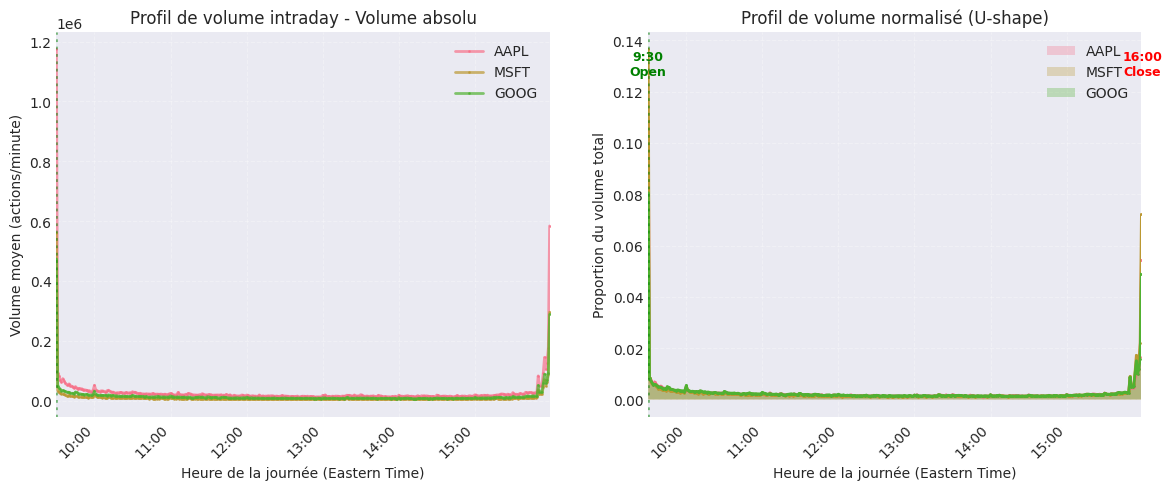

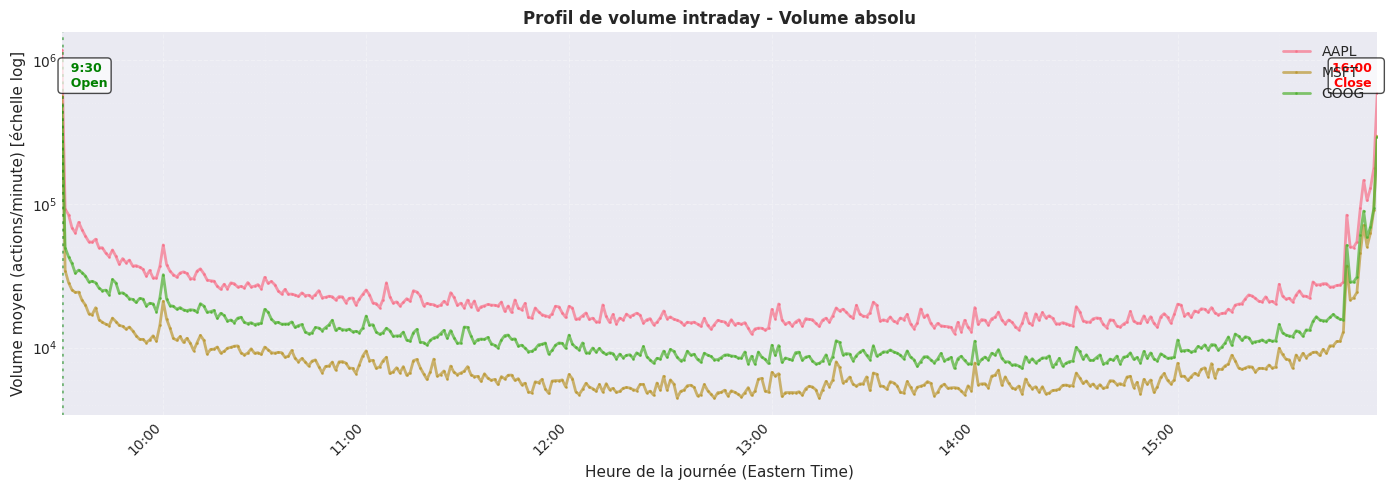


📈 Analyse de la U-shape :

AAPL :
  Volume max à 09:30:00 (10.89% du volume total)
  Volume min à 12:54:00 (0.12% du volume total)
  30 premières minutes : 24.0% du volume
  30 dernières minutes : 18.3% du volume

MSFT :
  Volume max à 09:30:00 (13.64% du volume total)
  Volume min à 13:14:00 (0.11% du volume total)
  30 premières minutes : 25.4% du volume
  30 dernières minutes : 22.1% du volume

GOOG :
  Volume max à 09:30:00 (8.06% du volume total)
  Volume min à 14:14:00 (0.12% du volume total)
  30 premières minutes : 21.4% du volume
  30 dernières minutes : 18.5% du volume


In [133]:
import matplotlib.dates as mdates

# ============================================================
# Calcul de la courbe de volume intraday (U-shape)
# ============================================================

volume_profiles = {}
eastern = pytz.timezone('US/Eastern')

for ticker in TICKERS:
    data = df_market[df_market['ticker'] == ticker].copy()
    
    # Exclure les volumes = 0 (gaps comblés)
    data = data[data['volume'] > 0]
    
    # Convertir en Eastern Time pour le groupement
    data_et = data.copy()
    data_et.index = data_et.index.tz_convert(eastern)
    
    # Grouper par heure:minute (en ET)
    volume_profile = data_et.groupby(data_et.index.time)['volume'].mean()
    
    # Normaliser
    volume_profile_normalized = volume_profile / volume_profile.sum()
    
    # Créer des timestamps datetime complets pour matplotlib
    # On utilise une date arbitraire (2025-01-15) mais on garde l'info de timezone
    reference_date = datetime(2025, 1, 15)
    datetimes_et = [eastern.localize(datetime.combine(reference_date, t)) 
                    for t in volume_profile.index]
    
    volume_profiles[ticker] = {
        'V_t': volume_profile,
        'V_t_normalized': volume_profile_normalized,
        'V_total': volume_profile.sum(),
        'timestamps': volume_profile.index,  # time objects
        'datetimes_et': datetimes_et  # datetime objects avec timezone
    }
    
    print(f"{ticker} :")
    print(f"  Volume total jour : {volume_profile.sum():,.0f} actions")
    print(f"  Volume min        : {volume_profile.min():,.0f} actions/min")
    print(f"  Volume max        : {volume_profile.max():,.0f} actions/min")
    print(f"  Ratio max/min     : {volume_profile.max() / volume_profile.min():.2f}x")


# ============================================================
# Visualisation de la U-shape avec heures en Eastern Time
# ============================================================

# Déterminer la plage horaire (en ET)
all_datetimes = []
for ticker in TICKERS:
    all_datetimes.extend(volume_profiles[ticker]['datetimes_et'])

datetime_min_et = min(all_datetimes)
datetime_max_et = max(all_datetimes)

print(f"\n📊 Plage horaire des données (Eastern Time) :")
print(f"   {datetime_min_et.strftime('%H:%M %Z')} → {datetime_max_et.strftime('%H:%M %Z')}")

# Créer la figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ============================================================
# Plot 1 : Volume absolu
# ============================================================

for ticker in TICKERS:
    datetimes = volume_profiles[ticker]['datetimes_et']
    values = volume_profiles[ticker]['V_t'].values
    
    axes[0].plot(datetimes, values, 
                 label=ticker, linewidth=2, alpha=0.7, marker='o', markersize=1)

axes[0].set_xlabel('Heure de la journée (Eastern Time)')
axes[0].set_ylabel('Volume moyen (actions/minute)')
axes[0].set_title('Profil de volume intraday - Volume absolu')
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3, linestyle='--')

# Formater l'axe x avec heures ET
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=eastern))
axes[0].xaxis.set_major_locator(mdates.HourLocator(interval=1))
axes[0].xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0, 30]))
axes[0].set_xlim([datetime_min_et, datetime_max_et])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Ajouter les heures importantes (ouverture/clôture)
market_open = eastern.localize(datetime(2025, 1, 15, 9, 30))
market_close = eastern.localize(datetime(2025, 1, 15, 16, 0))
axes[0].axvline(market_open, color='green', linestyle=':', alpha=0.5, linewidth=2, label='9:30 (Open)')
axes[0].axvline(market_close, color='red', linestyle=':', alpha=0.5, linewidth=2, label='16:00 (Close)')

# ============================================================
# Plot 2 : Distribution normalisée (U-shape)
# ============================================================

for ticker in TICKERS:
    datetimes = volume_profiles[ticker]['datetimes_et']
    values = volume_profiles[ticker]['V_t_normalized'].values
    
    axes[1].fill_between(datetimes, values, alpha=0.3, label=ticker)
    axes[1].plot(datetimes, values, linewidth=2, marker='o', markersize=1)

axes[1].set_xlabel('Heure de la journée (Eastern Time)')
axes[1].set_ylabel('Proportion du volume total')
axes[1].set_title('Profil de volume normalisé (U-shape)')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3, linestyle='--')

# Formater l'axe x avec heures ET
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=eastern))
axes[1].xaxis.set_major_locator(mdates.HourLocator(interval=1))
axes[1].xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0, 30]))
axes[1].set_xlim([datetime_min_et, datetime_max_et])
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Ajouter les heures importantes
axes[1].axvline(market_open, color='green', linestyle=':', alpha=0.5, linewidth=2)
axes[1].axvline(market_close, color='red', linestyle=':', alpha=0.5, linewidth=2)

# Annotations
axes[1].text(market_open, axes[1].get_ylim()[1]*0.95, '9:30\nOpen', 
             ha='center', va='top', fontsize=9, color='green', fontweight='bold')
axes[1].text(market_close, axes[1].get_ylim()[1]*0.95, '16:00\nClose', 
             ha='center', va='top', fontsize=9, color='red', fontweight='bold')

# ============================================================
# Visualisation de la U-shape avec échelle logarithmique
# ============================================================

# Déterminer la plage horaire (en ET)
all_datetimes = []
for ticker in TICKERS:
    all_datetimes.extend(volume_profiles[ticker]['datetimes_et'])

datetime_min_et = min(all_datetimes)
datetime_max_et = max(all_datetimes)

print(f"\n📊 Plage horaire des données (Eastern Time) :")
print(f"   {datetime_min_et.strftime('%H:%M %Z')} → {datetime_max_et.strftime('%H:%M %Z')}")

# Créer la figure
fig, axes = plt.subplots(1, figsize=(14, 5))

# ============================================================
# Plot 3 : Volume absolu (ÉCHELLE LOGARITHMIQUE)
# ============================================================

for ticker in TICKERS:
    datetimes = volume_profiles[ticker]['datetimes_et']
    values = volume_profiles[ticker]['V_t'].values
    
    axes.plot(datetimes, values, 
                 label=ticker, linewidth=2, alpha=0.7, marker='o', markersize=1)

# ✅ ÉCHELLE LOGARITHMIQUE
axes.set_yscale('log')

axes.set_xlabel('Heure de la journée (Eastern Time)', fontsize=11)
axes.set_ylabel('Volume moyen (actions/minute) [échelle log]', fontsize=11)
axes.set_title('Profil de volume intraday - Volume absolu', fontsize=12, fontweight='bold')
axes.legend(loc='upper right')
axes.grid(alpha=0.3, linestyle='--', which='both')  # Grid pour major et minor ticks
axes.grid(alpha=0.15, linestyle=':', which='minor')  # Grid plus léger pour minor ticks

# Formater l'axe x avec heures ET
axes.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=eastern))
axes.xaxis.set_major_locator(mdates.HourLocator(interval=1))
axes.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0, 30]))
axes.set_xlim([datetime_min_et, datetime_max_et])
plt.setp(axes.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Ajouter les heures importantes
market_open = eastern.localize(datetime(2025, 1, 15, 9, 30))
market_close = eastern.localize(datetime(2025, 1, 15, 16, 0))
axes.axvline(market_open, color='green', linestyle=':', alpha=0.5, linewidth=2)
axes.axvline(market_close, color='red', linestyle=':', alpha=0.5, linewidth=2)

# Annotations
y_pos_open = axes.get_ylim()[1] * 0.5  # Position au milieu de l'échelle log
axes.text(market_open, y_pos_open, '  9:30\n  Open', 
             ha='left', va='center', fontsize=9, color='green', 
             fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', 
                                          facecolor='white', alpha=0.7))
axes.text(market_close, y_pos_open, '16:00  \nClose  ', 
             ha='right', va='center', fontsize=9, color='red', 
             fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', 
                                          facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('results/figures/intraday_volume_profile.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# Afficher quelques statistiques sur la U-shape
# ============================================================

print("\n📈 Analyse de la U-shape :")
for ticker in TICKERS:
    times = volume_profiles[ticker]['timestamps']
    values = volume_profiles[ticker]['V_t_normalized'].values
    
    # Trouver les pics
    idx_max = values.argmax()
    idx_min = values.argmin()
    
    print(f"\n{ticker} :")
    print(f"  Volume max à {times[idx_max]} ({values[idx_max]*100:.2f}% du volume total)")
    print(f"  Volume min à {times[idx_min]} ({values[idx_min]*100:.2f}% du volume total)")
    
    # Volume première heure vs dernière heure
    first_30min = values[:30].sum() if len(values) >= 30 else values[:len(values)//2].sum()
    last_30min = values[-30:].sum() if len(values) >= 30 else values[len(values)//2:].sum()
    print(f"  30 premières minutes : {first_30min*100:.1f}% du volume")
    print(f"  30 dernières minutes : {last_30min*100:.1f}% du volume")

In [134]:
## Estimation des paramètres
for ticker in TICKERS:
    print(f"\n🔹 {ticker}")
    print("-" * 70)
    
    # Filtrer les données du ticker
    data = df_market[df_market['ticker'] == ticker].copy()
    
    # Exclure les volumes = 0 (gaps comblés artificiellement)
    data = data[data['volume'] > 0]
    
    # ========================================
    # 1. Calcul de la volatilité (σ)
    # ========================================
    
    # Calculer les log returns si pas déjà fait
    if 'log_return' not in data.columns:
        data['log_return'] = np.log(data['close'] / data['close'].shift(1))
    
    # Volatilité intraday (par minute)
    vol_minute = data['log_return'].std()
    
    # Annualisation : 252 jours de trading, 390 minutes par jour (6.5h × 60min)
    sigma_annual = vol_minute * np.sqrt(252 * 390)
    
    # Volatilité journalière (utile pour Almgren-Chriss)
    sigma_daily = vol_minute * np.sqrt(390)
    
    print(f"  σ (volatilité) :")
    print(f"    • Par minute    : {vol_minute:.6f}")
    print(f"    • Journalière   : {sigma_daily:.4f}")
    print(f"    • Annualisée    : {sigma_annual:.4f}")

    # Prendre uniquement le dernier prix de chaque jour
    daily_closes = data.groupby(data.index.date)['close'].last()
    
    # Log returns journaliers
    daily_returns = np.log(daily_closes / daily_closes.shift(1))
    vol_daily = daily_returns.std()
    
    # Annualisation journalière (252 jours)
    sigma_daily_based = vol_daily * np.sqrt(252)
    
    print(f"\n  📊 Volatilité JOURNALIÈRE (close-to-close) :")
    print(f"     • σ par jour    : {vol_daily:.6f}")
    print(f"     • σ annualisée  : {sigma_daily_based:.4f} ({sigma_daily_based*100:.2f}%)")

    


🔹 AAPL
----------------------------------------------------------------------
  σ (volatilité) :
    • Par minute    : 0.001273
    • Journalière   : 0.0251
    • Annualisée    : 0.3992

  📊 Volatilité JOURNALIÈRE (close-to-close) :
     • σ par jour    : 0.025367
     • σ annualisée  : 0.4027 (40.27%)

🔹 MSFT
----------------------------------------------------------------------
  σ (volatilité) :
    • Par minute    : 0.001036
    • Journalière   : 0.0205
    • Annualisée    : 0.3247

  📊 Volatilité JOURNALIÈRE (close-to-close) :
     • σ par jour    : 0.018684
     • σ annualisée  : 0.2966 (29.66%)

🔹 GOOG
----------------------------------------------------------------------
  σ (volatilité) :
    • Par minute    : 0.001149
    • Journalière   : 0.0227
    • Annualisée    : 0.3601

  📊 Volatilité JOURNALIÈRE (close-to-close) :
     • σ par jour    : 0.022669
     • σ annualisée  : 0.3599 (35.99%)
